In [2]:
import GOES as GOES
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import pandas as pd

from os import listdir
from os.path import isfile, join
# import cartopy.crs as ccrs
import numpy as np
# from cartopy.feature import NaturalEarthFeature

import import_ipynb
import Utilities as util

importing Jupyter notebook from Utilities.ipynb


Download two subsequent images per day for a period of one month. Plot the density in the c-d space and also try to make a vector pace.

In [80]:
## download correct data and put in daily_data
# download the data
list_dates = [{'year': '2020',
          'months': ['01', '02'],
              'days_per_month': [31, 29]}]

dates_string = []
for dates in list_dates:
    m = 0
    for month in dates['months']:
        for day in range(1, dates['days_per_month'][m] + 1):
            date = dates['year'] + month + str(day).rjust(2, '0')
            dates_string.append(date)
        m +=1


# for date in dates_string:
#     DateTimeIni = date + '-153000'
#     DateTimeFin = date + '-155000'
#     flist_cth = GOES.download('goes16', 'ABI-L2-ACHAF', # see https://www.noaa.gov/organization/information-technology/list-of-big-data-program-datasets for product names
#                           DateTimeIni = DateTimeIni, DateTimeFin = DateTimeFin, 
#                           path_out='./data_daily/')

#     flist_cod = GOES.download('goes16', 'ABI-L2-CODF', # see https://www.noaa.gov/organization/information-technology/list-of-big-data-program-datasets for product names
#                           DateTimeIni = DateTimeIni, DateTimeFin = DateTimeFin, 
#                           path_out='./data_daily/')




In [ ]:
path = './data_daily/'
flist_cth = [path + f for f in listdir(path) if (isfile(join(path, f)) and 'ACHAF' in f)]
flist_cod = [path + f for f in listdir(path) if (isfile(join(path, f)) and 'CODF' in f)]
flist_cth
util.rawDatatoClassification(flist_cth, flist_cod, output_loc = 'output_daily')


In [24]:
day = pd.DatetimeIndex([image.time.data]).day[0]

day
for i in range(10):
    if i % 2 == 0:
        continue
    print(i)

1
3
5
7
9


In [30]:
## open data and make density plot
path = './output_daily/'
files = [path + f for f in listdir(path) if isfile(join(path, f))]
files

df = pd.DataFrame(columns = ['COD', 'CTH', 'ct'])
day = 0
for file in files:
    image = xr.open_dataset(file)
    day_temp = pd.DatetimeIndex([image.time.data]).day[0]
    if day_temp == day: 
        continue
    df_add = pd.DataFrame(np.array([image.cod.data.flatten(),
                                    image.cth.data.flatten(), 
                                    image.ct.data.flatten()]).T, columns = ['COD', 'CTH', 'ct'])
    df = df.append(df_add.loc[df_add.ct != 0].loc[df_add.ct != 1].loc[np.isnan(df_add.CTH)!= True], ignore_index=True)
    day = day_temp
    print(day, end = '\r')
df

,COD,CTH,ct
0,NaN,NaN,1.0
1,NaN,NaN,1.0
2,NaN,NaN,1.0
3,NaN,NaN,1.0
4,NaN,NaN,1.0
...,...,...,...
13545051,1.120708,13492.445312,4.0
13545052,1.018160,13418.281250,4.0
13545053,0.817946,13418.281250,4.0
13545054,1.008393,10935.753906,4.0


In [58]:
df = df.loc[df.ct!= 1].loc[np.isnan(df.CTH)!= True]


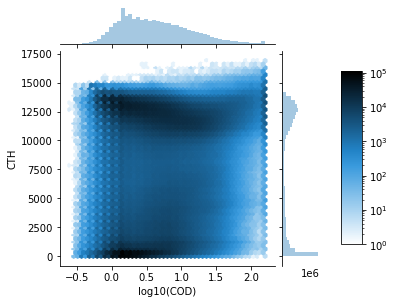

In [67]:
# library & dataset
import seaborn as sns
import matplotlib.pyplot as plt

# # Custom the inside plot: options are: “scatter” | “reg” | “resid” | “kde” | “hex”
h = sns.jointplot(x=np.log10(df["COD"]), y=df["CTH"], kind='hex',  norm=mpl.colors.LogNorm())
h.ax_joint.set_xlabel('log10(COD)')
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
# make new ax object for the cbar
cbar_ax = h.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
plt.colorbar(cax=cbar_ax)


# Custom the color, add shade and bandwidth
# sns.kdeplot(df, cmap="Reds", shade=True, bw_adjust=.5)
plt.savefig('./fig/Density plot Jan-Feb 2020')
plt.show()

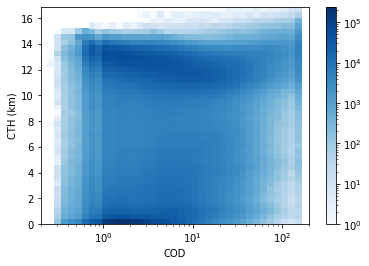

In [75]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import kde
 
# Create data: 200 points
x = df["COD"]
y = df["CTH"]

# 2D Histogram
fig = plt.figure()
nbins = 40
bins = [np.logspace(np.log10(0.2),np.log10(200.0), nbins),nbins]
# plt.title('2D Histogram')
plt.hist2d(x, y*1e-3, bins=bins, cmap=plt.cm.Blues, norm=mpl.colors.LogNorm())
plt.xlabel('COD')
plt.ylabel('CTH (km)')
plt.xscale('log')
plt.colorbar()
plt.show()

In [148]:
## vectorplot

## open data and make density plot
path = './output_daily/'
files = [path + f for f in listdir(path) if isfile(join(path, f))]
files
columns = ['COD1', 'CTH1', 'ct1', 'ct2', 'dCOD', 'dCODdB', 'dCTH']
df = pd.DataFrame(columns = columns)
for date in dates_string:

    files = [path + f for f in listdir(path) if (isfile(join(path, f)) and date in f)]
    if len(files)<2:
        print(f'{date}: not enough files')
        continue
    image1 = xr.open_dataset(files[0])
    image2 = xr.open_dataset(files[1])
    

    df_add = pd.DataFrame(np.array([image1.cod.data.flatten(),
                                    image1.cth.data.flatten(), 
                                    image1.ct.data.flatten(), 
                                    image2.ct.data.flatten(), 
                                    image2.cod.data.flatten() - image1.cod.data.flatten(),
                                    np.log10(image2.cod.data.flatten()) - np.log10(image1.cod.data.flatten()),
                                    image2.cth.data.flatten() - image1.cth.data.flatten()
                                   ]).T, columns = columns)
    df = df.append(df_add
                   .loc[df_add.ct1 != 0]
                   .loc[df_add.ct1 != 1]
                   .loc[np.isnan(df_add.CTH1)!= True]
                   .loc[np.isnan(df_add.dCTH)!= True]
                   .loc[df_add.ct2 != 0]
                   .loc[df_add.ct2 != 1]
                   , ignore_index=True)
    print(date, end = '\r')
df

20200106: not enough files
20200109: not enough files


,COD1,CTH1,ct1,ct2,dCOD,dCODdB,dCTH
0,3.974974,437.356903,5.0,5.0,1.545552,0.142646,-132.763611
1,5.461926,437.356903,5.0,5.0,-1.391729,-0.127730,-132.763611
2,1.096292,437.356903,2.0,2.0,2.287807,0.489517,-132.763611
3,2.605219,244.773376,2.0,2.0,-1.584618,-0.406988,58.293915
4,0.886312,524.034790,2.0,2.0,0.629941,0.233185,192.583496
...,...,...,...,...,...,...,...
9464682,1.120708,13492.445312,4.0,4.0,-0.090340,-0.036500,87.288086
9464683,1.018160,13418.281250,4.0,4.0,0.053716,0.022328,29.298828
9464684,0.817946,13418.281250,4.0,4.0,0.000000,0.000000,29.298828
9464685,1.008393,10935.753906,4.0,4.0,-0.195330,-0.093506,2706.851562


(array([4.400000e+01, 1.987000e+03, 3.489000e+04, 4.067120e+05,
        4.991875e+06, 3.681389e+06, 3.169520e+05, 2.867900e+04,
        2.085000e+03, 7.400000e+01]),
 array([-2.16525292, -1.72458725, -1.28392158, -0.8432559 , -0.40259023,
         0.03807545,  0.47874112,  0.9194068 ,  1.36007247,  1.80073814,
         2.24140382]),
 <a list of 10 Patch objects>)

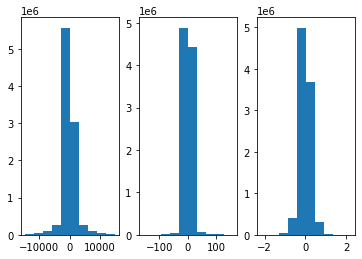

In [182]:
fig, ax = plt.subplots(1,3)
ax[0].hist(df.dCTH)
ax[1].hist(df.dCOD)
ax[2].hist(df.dCODdB)

In [195]:
y = df.COD1
x = df.CTH1
z_cth = df.dCTH
z_coddB = df.dCODdB
z_cod = df.dCOD

nbins = [60,61]
bins = [nbins[0], np.logspace(np.log10(0.2),np.log10(200.0), nbins[1])]

counts, xbins, ybins = np.histogram2d(x, y, bins=bins)
sums_cth, _, _ = np.histogram2d(x, y, weights=z_cth, bins=(xbins, ybins))
sums_cod, _, _ = np.histogram2d(x, y, weights=z_cod, bins=(xbins, ybins))
sums_coddB, _, _ = np.histogram2d(x, y, weights=z_coddB, bins=(xbins, ybins))

mean_cth = sums_cth / counts
mean_cod = sums_cod / counts
mean_coddB = sums_coddB / counts


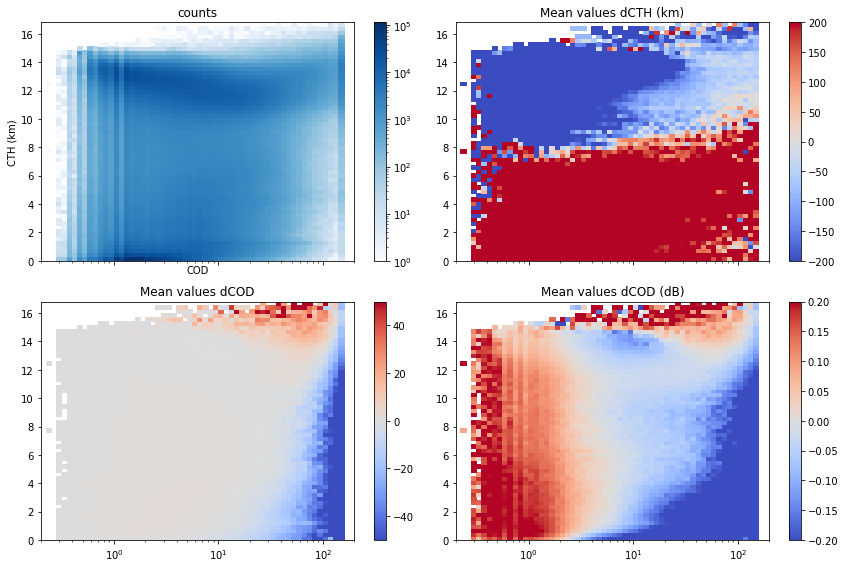

In [202]:
fig, ((ax1, ax4), (ax2, ax3)) = plt.subplots(ncols=2, nrows = 2, figsize=(12, 8), sharex = True)
m1 = ax1.pcolormesh(ybins, xbins / 1e3, counts, cmap=plt.cm.Blues, norm=mpl.colors.LogNorm())
plt.colorbar(m1, ax=ax1)
ax1.set_xscale('log')
ax1.set_xlabel('COD')
ax1.set_ylabel('CTH (km)')
ax1.set_title('counts')

with np.errstate(divide='ignore', invalid='ignore'):  # suppress possible divide-by-zero warnings
    m2 = ax2.pcolormesh(ybins, xbins / 1e3, mean_cod, cmap='coolwarm', vmin = -50, vmax = 50)
plt.colorbar(m2, ax=ax2)
ax2.set_title('Mean values dCOD')

with np.errstate(divide='ignore', invalid='ignore'):  # suppress possible divide-by-zero warnings
    m3 = ax3.pcolormesh(ybins, xbins / 1e3, mean_coddB, cmap='coolwarm', vmin = -.2, vmax = .2)
plt.colorbar(m3, ax=ax3)
ax3.set_title('Mean values dCOD (dB)')

with np.errstate(divide='ignore', invalid='ignore'):  # suppress possible divide-by-zero warnings
    m4 = ax4.pcolormesh(ybins, xbins / 1e3, mean_cth, cmap='coolwarm', vmin = -200, vmax = 200)
plt.colorbar(m4, ax=ax4)
ax4.set_title('Mean values dCTH (km)')
plt.tight_layout()
plt.show()

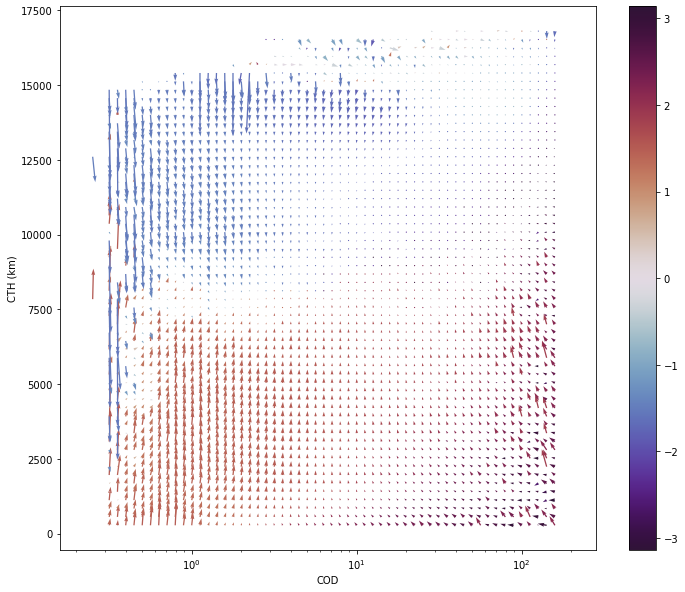

In [203]:
plt.figure(figsize = (12,10))
with np.errstate(divide='ignore', invalid='ignore'):  # suppress possible divide-by-zero warnings
    u = sums_coddB / counts
    v = sums_cth / counts / 1e3
    c = np.arctan2(v, u)
    plt.quiver(ybins[1:],xbins[1:], u, v, c, cmap = 'twilight_shifted')
plt.colorbar()
plt.xscale('log')
plt.xlabel('COD')
plt.ylabel('CTH (km)')
plt.show()

mason -> iscip classification/ justification
christian.jakob@monash.edu
 - classification, based on type of measurements, what do we do with not seeing the congestus
     look into iscip climotology
 - how to deal with advection. 
 - 
 
 - derived motions data
 
 